In [1]:
#!pip install --user numpy
#!pip install pandas
#!python -m pip install -U matplotlib
#!python -m pip install -U scikit-image
#!pip install -U scikit-learn
#!pip install keras
#!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread

In [3]:
base_dir = '/kaggle/input/airbus-ship-detection'
train_dir = base_dir + '/train_v2/'
test_dir = base_dir + '/test_v2/'

In [4]:
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

print(f"Found {len(train_files)} train images")
print(f"Found {len(test_files)} test images")

Found 192556 train images
Found 15606 test images


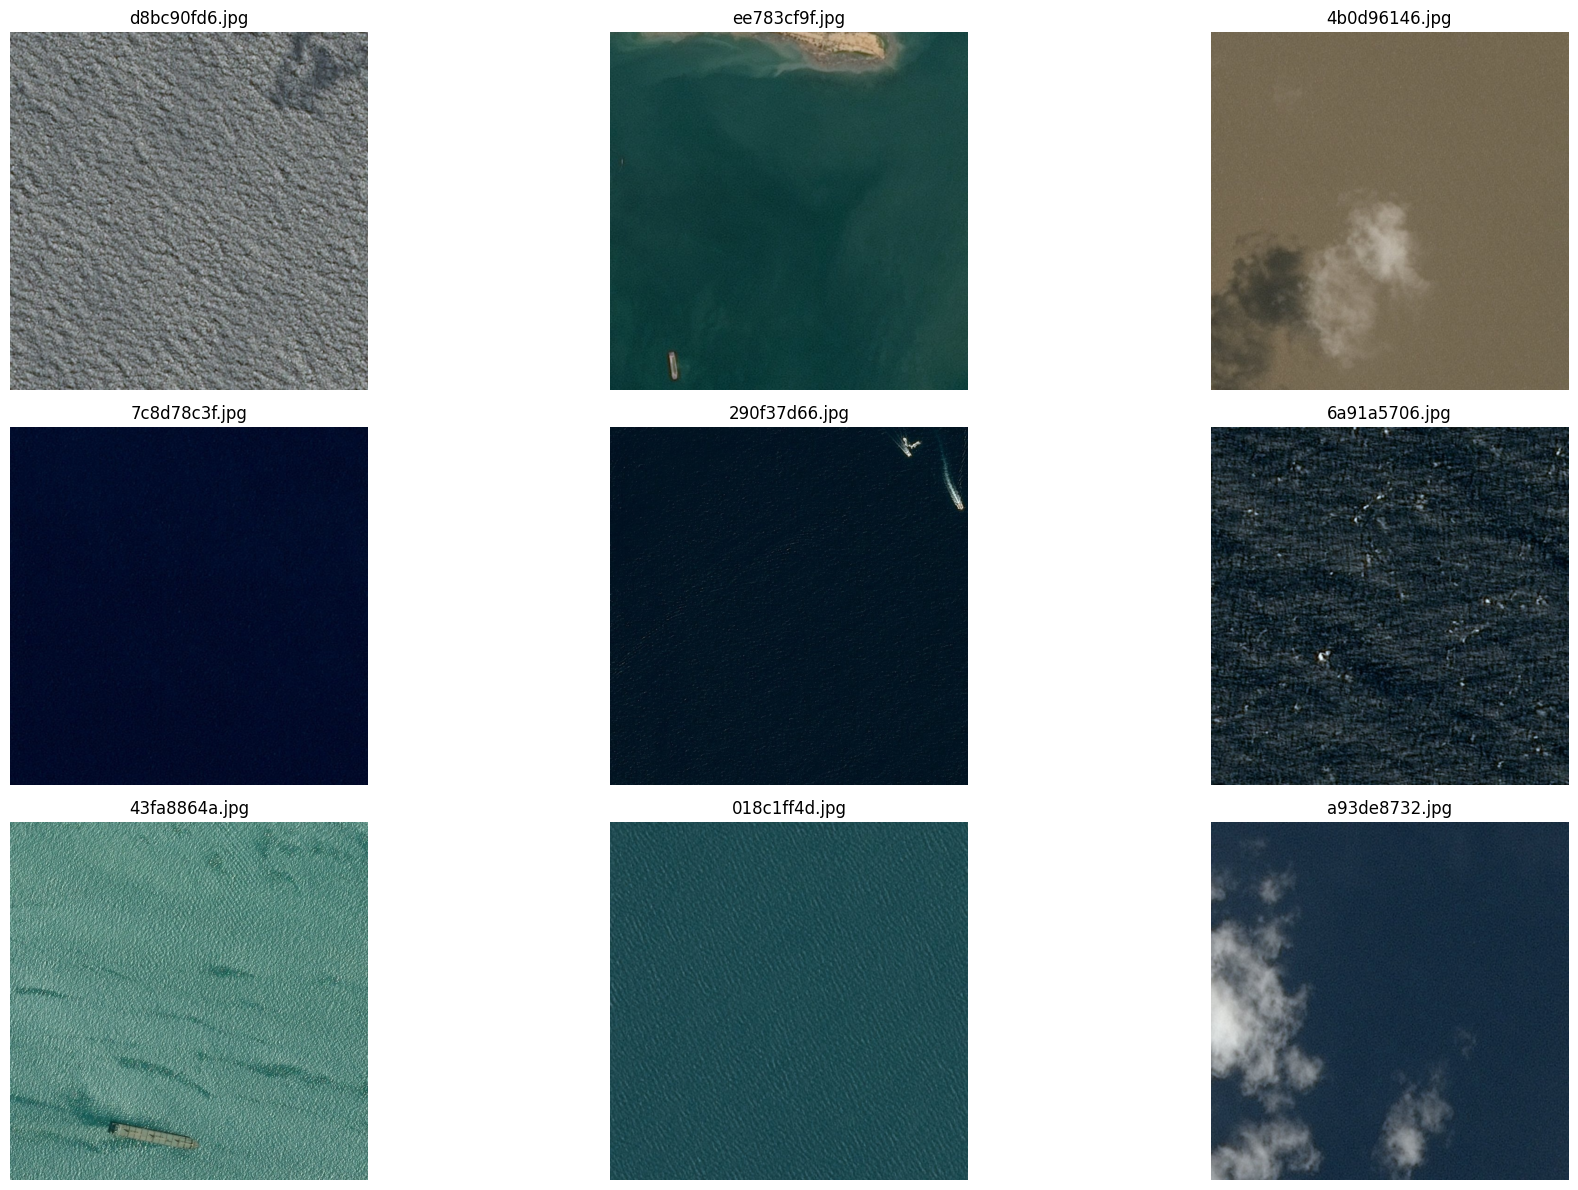

In [5]:
plt.figure(figsize=(20, 12))
for i in range(0, 9, 3):
    for j in range(3):
        plt.subplot(3, 3, i+j+1)
        plt.title(train_files[i+j])
        plt.imshow(imread(os.path.join(train_dir, train_files[i+j])))
        plt.axis(False)
plt.tight_layout()

In [6]:
train_masks = pd.read_csv(os.path.join(base_dir, 'train_ship_segmentations_v2.csv'))
not_empty_masks = pd.notna(train_masks.EncodedPixels)
print(not_empty_masks.sum(), 'masks in', train_masks[not_empty_masks].ImageId.nunique(), 'images')
print((~not_empty_masks).sum(), 'empty images out of', train_masks.ImageId.nunique(), 'total images')
train_masks.head()

81723 masks in 42556 images
150000 empty images out of 192556 total images


ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [7]:
img_path = os.path.join(train_dir, train_files[0])
im_size = imread(img_path).shape
print(f"Image size: {im_size}")

Image size: (768, 768, 3)


In [8]:
def decode_mask(mask, shape):
    mask_split = mask.split()
    starts, lengths = [np.array(x, dtype=int) for x in (mask_split[0::2], mask_split[1::2])]
    starts -= 1
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for start, length in zip(starts, lengths):
        img[start:start+length] = 1
    return img.reshape(shape).T


def decode_image(masks, shape=im_size[:2]):
    decoded = np.zeros(shape, dtype = np.uint8)
    for mask in masks:
        if isinstance(mask, str):
            decoded |= decode_mask(mask, shape)
    return decoded

In [9]:
train_masks['has_ships'] = train_masks['EncodedPixels'].map(lambda x: 1 if isinstance(x, str) else 0)
unique_img_df = train_masks.groupby('ImageId').agg({'has_ships': 'sum'}).reset_index()
unique_img_df.rename(columns={"has_ships": "ships_count"}, inplace=True)
unique_img_df['has_ships'] = unique_img_df['ships_count'].map(lambda x: 1.0 if x>0 else 0.0)
train_masks.drop(['has_ships'], axis=1, inplace=True)
unique_img_df.head()

ImageId  ships_count  has_ships
0  00003e153.jpg            0        0.0
1  0001124c7.jpg            0        0.0
2  000155de5.jpg            1        1.0
3  000194a2d.jpg            5        1.0
4  0001b1832.jpg            0        0.0

Avg amount of ships:  0.4244115997424126


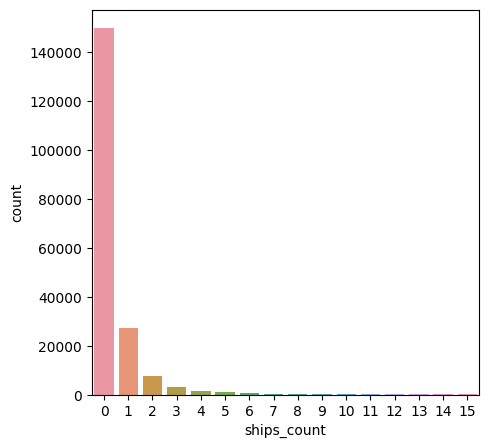

In [10]:
import seaborn as sns

plt.figure(figsize=(5,5))
sns.countplot(data=unique_img_df, x='ships_count')
print('Avg amount of ships: ',unique_img_df['ships_count'].mean())

In [11]:
unique_img_df.ships_count.value_counts()

ships_count
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: count, dtype: int64

In [12]:
unique_img_df['grouped_ships_count'] = unique_img_df['ships_count'].map(lambda x: (x+1)//2).clip(0,7)
unique_img_df.grouped_ships_count.value_counts()

grouped_ships_count
0    150000
1     34778
2      4576
3      1582
4       724
5       411
6       268
7       217
Name: count, dtype: int64

In [13]:
def undersample(series, sample_size=1000):
    if series["has_ships"].iloc[0] == 0.0:
        return series.sample(min(series.shape[0], sample_size//2), replace=True)
    
    return series.sample(min(series.shape[0], sample_size), replace=True)    

In [14]:
balanced_img_df = unique_img_df.groupby('grouped_ships_count', group_keys=False).apply(undersample)
balanced_img_df.grouped_ships_count.value_counts()

/tmp/ipykernel_34/273959771.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_img_df = unique_img_df.groupby('grouped_ships_count', group_keys=False).apply(undersample)


grouped_ships_count
1    1000
2    1000
3    1000
4     724
0     500
5     411
6     268
7     217
Name: count, dtype: int64

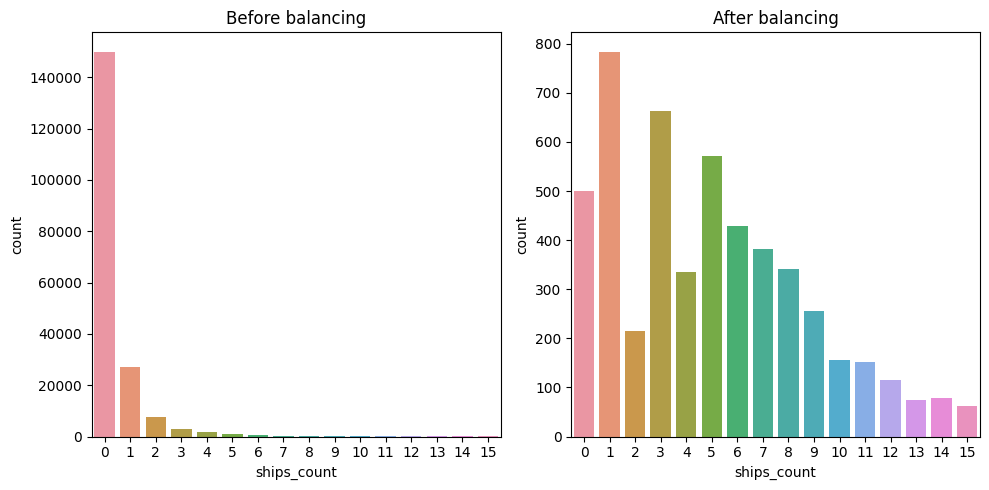

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Before balancing")
sns.countplot(data=unique_img_df, x='ships_count')
plt.subplot(1, 2, 2)
plt.title("After balancing")
sns.countplot(data=balanced_img_df, x='ships_count')
plt.tight_layout()

In [16]:
from sklearn.model_selection import train_test_split

train_ids, valid_ids = train_test_split(balanced_img_df, 
                 test_size = 0.2, 
                 stratify = balanced_img_df['ships_count'])

train_df = pd.merge(train_masks, train_ids)
val_df = pd.merge(train_masks, valid_ids)
print("Training data was split into:")
print('training images\t\t', train_df.shape[0])
print('validation images\t', val_df.shape[0])

Training data was split into:
training images		 20663
validation images	 5172


In [17]:
batch_size = 48
img_scale = (3, 3)
validation_batch = 900
steps = 10
epochs = 99

dg_args = {
            "rotation_range": 30, 
            "width_shift_range": 0.1, 
            "height_shift_range": 0.1, 
            "shear_range": 0.01,
            "zoom_range": [0.9, 1.25],  
            "horizontal_flip": True, 
            "vertical_flip": True,
            "fill_mode": "reflect",
            "data_format": "channels_last"
}

In [18]:
def create_gen(df, batch_size=batch_size):
    batches = list(df.groupby('ImageId'))
    img_batch = []
    masks_batch = []
    while True:
        np.random.shuffle(batches)
        for img_id, masks in batches:
            img_path = os.path.join(train_dir, img_id)
            img = imread(img_path)
            mask = np.expand_dims(decode_image(masks['EncodedPixels'].values), -1)
            
            if img_scale is not None:
                img = img[::img_scale[0], ::img_scale[1]]
                mask = mask[::img_scale[0], ::img_scale[1]]
                
            img_batch.append(img)
            masks_batch.append(mask)
            if len(img_batch) >= batch_size:
                yield np.stack(img_batch, 0)/255., np.stack(masks_batch, 0).astype(np.float32)
                img_batch, masks_batch = [], []

In [19]:
train_gen = create_gen(train_df)
X_train, y_train = next(train_gen)
print('x', X_train.shape, X_train.min(), X_train.max())
print('y', y_train.shape, y_train.min(), y_train.max())

x (48, 256, 256, 3) 0.0 1.0
y (48, 256, 256, 1) 0.0 1.0


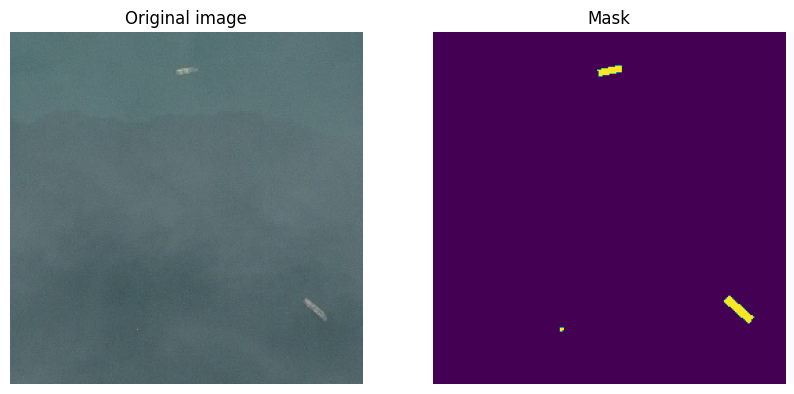

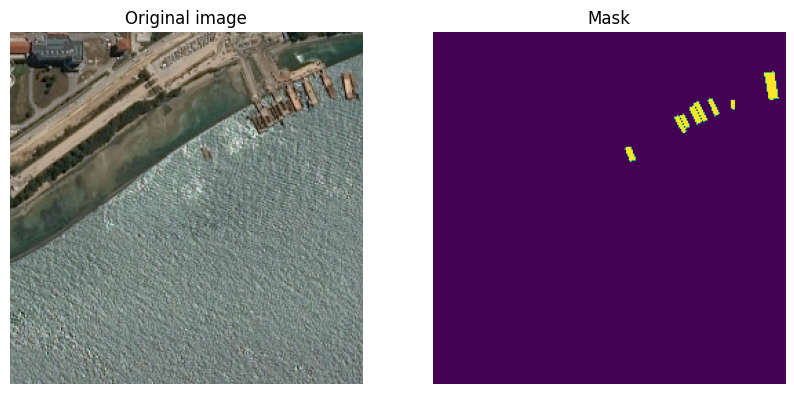

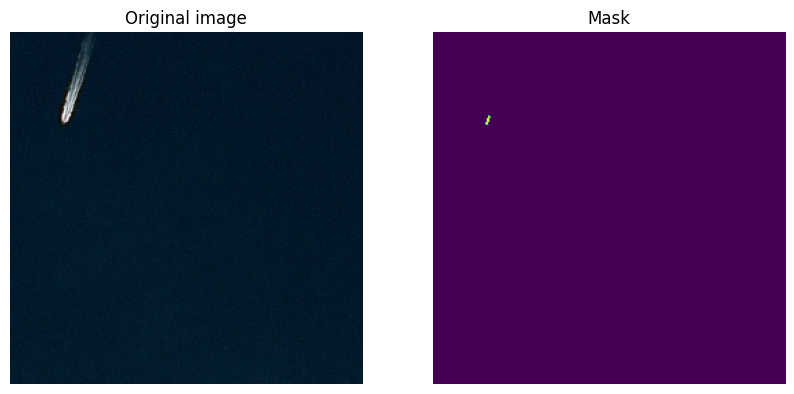

In [20]:
rows = 1
cols = 2

for i in range(3):
    fig = plt.figure(figsize=(10,5))
    fig.add_subplot(rows, cols, 1)
    plt.title("Original image")
    plt.imshow(X_train[i])
    plt.axis(False)
    fig.add_subplot(rows, cols, 2)
    plt.title("Mask")
    plt.imshow(y_train[i])
    plt.axis(False)

plt.show()

In [21]:
X_val, y_val = next(create_gen(val_df, validation_batch))
print(X_val.shape, y_val.shape)

(900, 256, 256, 3) (900, 256, 256, 1)


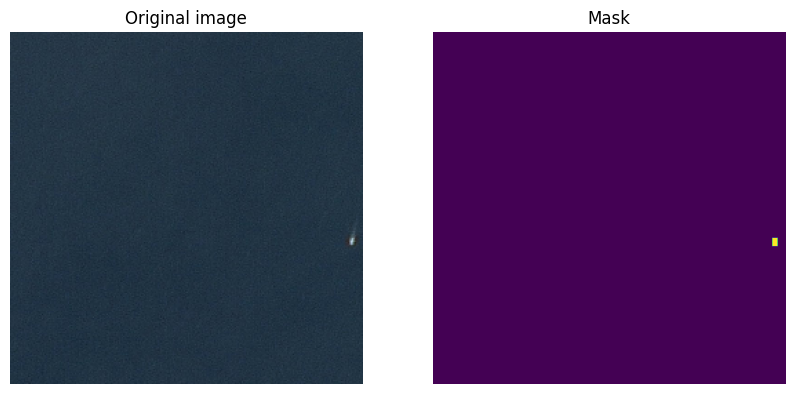

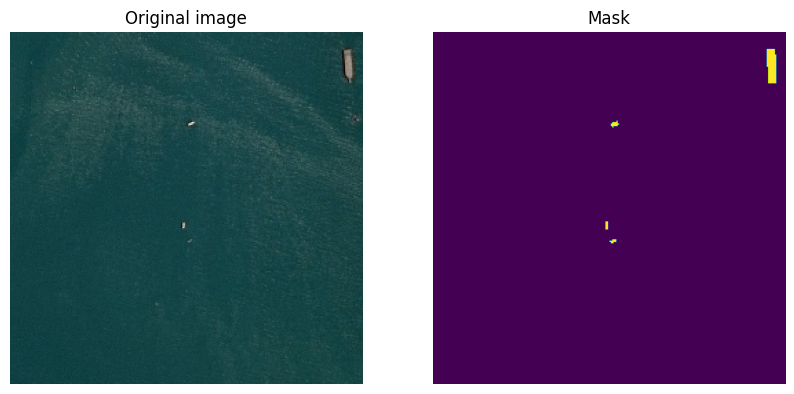

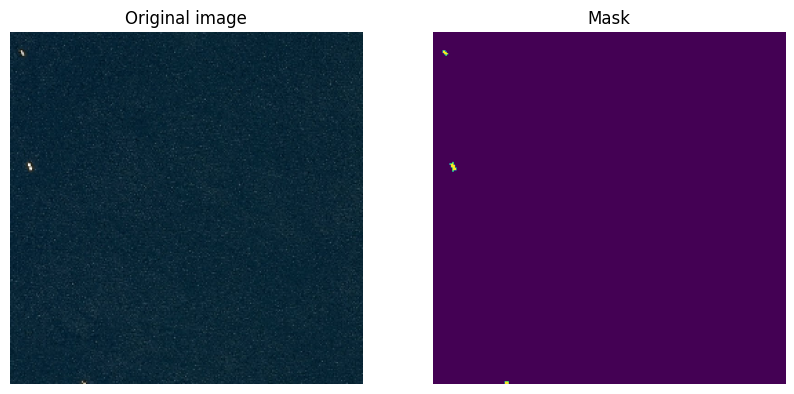

In [22]:
rows = 1
cols = 2

for i in range(3):
    fig = plt.figure(figsize=(10,5))
    fig.add_subplot(rows, cols, 1)
    plt.title("Original image")
    plt.imshow(X_val[i])
    plt.axis(False)
    fig.add_subplot(rows, cols, 2)
    plt.title("Mask")
    plt.imshow(y_val[i])
    plt.axis(False)

plt.show()

In [23]:
from keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(**dg_args)
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for im, masks in gen:
        seed = np.random.choice(range(9999))
        g_x = image_gen.flow(im, 
                             batch_size = im.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(masks, 
                             batch_size = im.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x), next(g_y)

2024-03-01 14:12:26.438246: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 14:12:26.438350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 14:12:26.701248: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [24]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

x (48, 256, 256, 3) float32 0.0 1.0
y (48, 256, 256, 1) float32 0.0 1.0


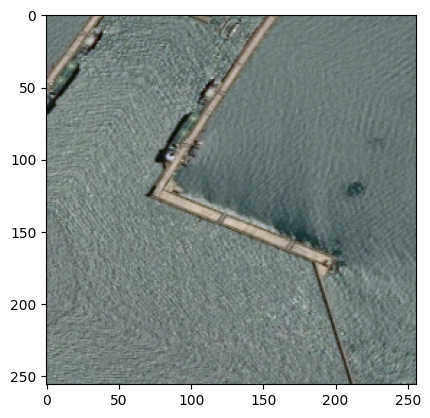

In [25]:
plt.imshow(t_x[37])

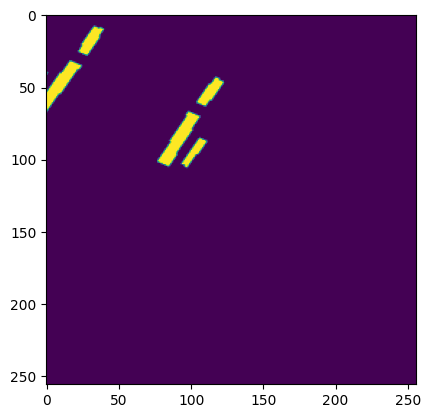

In [26]:
plt.imshow(t_y[37])

## 3. Modeling

### 3-1. Base Model

In [27]:
from tensorflow.keras import layers, models

def conv_block(input, filters, drop_rate):
    x = layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    return x


# Encoding block for U-Net architecture
def encoding_block(input, filters, drop_rate):
    x = conv_block(input, filters, drop_rate)
    return x, layers.MaxPooling2D((2, 2))(x)


# Decoding block for U-Net architecture
def decoder_block(input, processed, filters, drop_rate):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(input)
    x = layers.Concatenate()([x, processed])
    return conv_block(x, filters, drop_rate)


# Function which builds model based on U-Net architecture
def unet(pretrained_weights=None, input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    s1, p1 = encoding_block(inputs, 16, 0.1)
    s2, p2 = encoding_block(p1, 32, 0.1)
    s3, p3 = encoding_block(p2, 64, 0.2)
    s4, p4 = encoding_block(p3, 128, 0.2)

    b = conv_block(p4, 256, 0.3)

    d1 = decoder_block(b, s4, 128, 0.2)
    d2 = decoder_block(d1, s3, 64, 0.2)
    d3 = decoder_block(d2, s2, 32, 0.1)
    d4 = decoder_block(d3, s1, 16, 0.1)

    outputs = layers.Conv2D(1, (1, 1), padding="same", activation='sigmoid')(d4)

    model = models.Model(inputs=[inputs], outputs=[outputs], name="U-Net")

    if pretrained_weights:
        model.load_weights(pretrained_weights)

    return model

In [28]:
model = unet()
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

### 3-2. loss function

In [29]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

def DiceBCELoss(targets, inputs, smooth=1e-6):    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    inputs = K.expand_dims(inputs)
    targets = K.expand_dims(targets)
    
    BCE =  binary_crossentropy(targets, inputs)
    intersection = K.dot(K.transpose(targets), inputs)   
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

def DiceLoss(targets, inputs, smooth=1e-6):
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = K.expand_dims(inputs)
    targets = K.expand_dims(targets)

    intersection = K.dot(K.transpose(targets), inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

### 3-3. callbacks setting

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

weight_path="/kaggle/working/models/{}_weights.best.hdf5".format('unet')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_dice_coef',
                             verbose=1,
                             mode='max', 
                             save_weights_only=True, 
                             save_best_only=True)

reduceLR = ReduceLROnPlateau(monitor='val_dice_coef', 
                                   factor=0.5, 
                                   patience=5, 
                                   verbose=1, 
                                   mode='max',
                                   min_delta=0.0001,
                                   cooldown=2,
                                   min_lr=1e-6)

early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) 

callbacks_list = [checkpoint, early, reduceLR]

### 3-4. Training

In [31]:
model.compile(optimizer=Adam(1e-3), loss = DiceLoss, metrics=[dice_coef])

step_count = min(steps, train_df.shape[0]//batch_size)
aug_gen = create_aug_gen(create_gen(train_df))

loss_history = model.fit(aug_gen,
                         steps_per_epoch=steps,
                         epochs=epochs,
                         validation_data=(X_val, y_val),
                         callbacks=callbacks_list)

Epoch 1/99


2024-03-01 14:12:51.369384: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1709302382.827736     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - ETA: 0s - loss: 0.9845 - dice_coef: 0.0154
Epoch 1: val_dice_coef improved from -inf to 0.01853, saving model to /kaggle/working/models/unet_weights.best.hdf5
10/10 [==============================] - 56s 3s/step - loss: 0.9845 - dice_coef: 0.0154 - val_loss: 0.9821 - val_dice_coef: 0.0185 - lr: 0.0010
Epoch 2/99
10/10 [==============================] - ETA: 0s - loss: 0.9684 - dice_coef: 0.0307
Epoch 2: val_dice_coef improved from 0.01853 to 0.04663, saving model to /kaggle/working/models/unet_weights.best.hdf5
10/10 [==============================] - 16s 2s/step - loss: 0.9684 - dice_coef: 0.0307 - val_loss: 0.9760 - val_dice_coef: 0.0466 - lr: 0.0010
Epoch 3/99
10/10 [==============================] - ETA: 0s - loss: 0.8731 - dice_coef: 0.1179
Epoch 3: val_dice_coef improved from 0.04663 to 0.24457, saving model to /kaggle/working/models/unet_weights.best.hdf5
10/10 [==============================] - 19s 2s/step - loss: 0.8731 - dice_coef: 0.1

### 3-5. Full Resolution Mode

In [32]:
#if IMG_SCALING is not None:
    #fullres_model = models.Sequential()
    #fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    #fullres_model.add(seg_model)
    #fullres_model.add(layers.UpSampling2D(IMG_SCALING))
#else:
fullres_model = model
fullres_model.save('/kaggle/working/fullres_model & weights/fullres_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
#!pip install opencv-python
import tensorflow as tf
import cv2
rgb_path = os.path.join(test_dir,'00dc34840.jpg')#'00c3db267.jpg')
img = cv2.imread(rgb_path)/255
img = img[::img_scale[0], ::img_scale[1]]
img = tf.expand_dims(img, axis=0)
pred = fullres_model.predict(img)
print(pred[pred<0])

1/1 [==============================] - 1s 1s/step
[]


In [34]:
def create_pred_gen(test_dir, img, model):
    rgb_path = os.path.join(test_dir,img)
    img = cv2.imread(rgb_path)
    img = img[::img_scale[0], ::img_scale[1]]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255
    img = tf.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = np.squeeze(pred, axis=0)
    return cv2.imread(rgb_path), pred

1/1 [==============================] - 0s 24ms/step


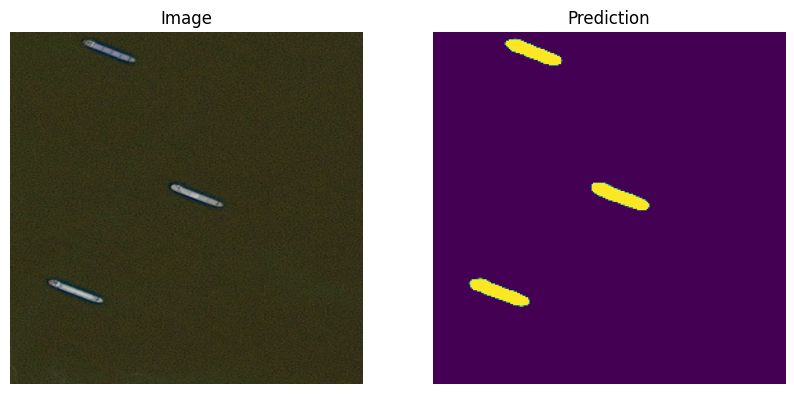

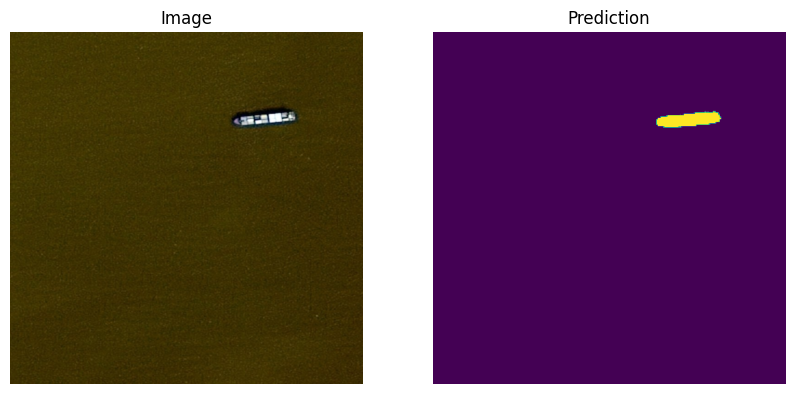

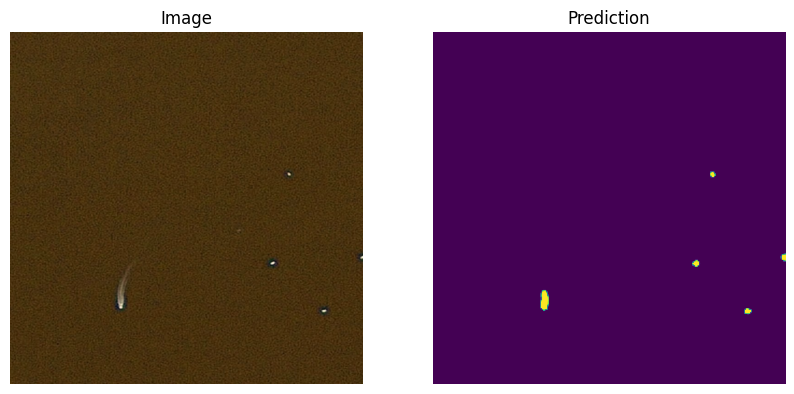

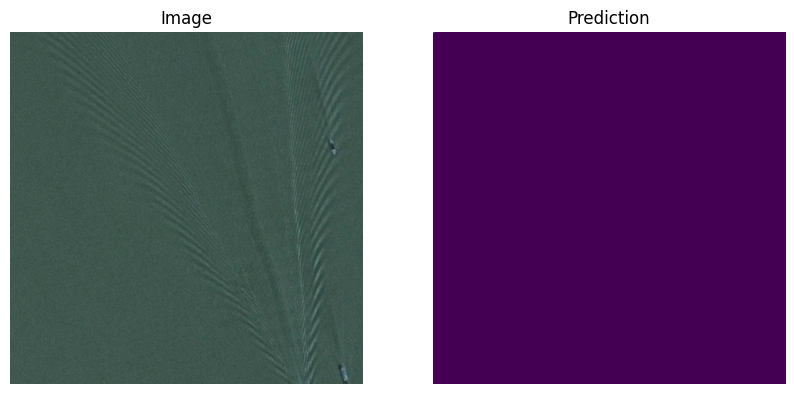

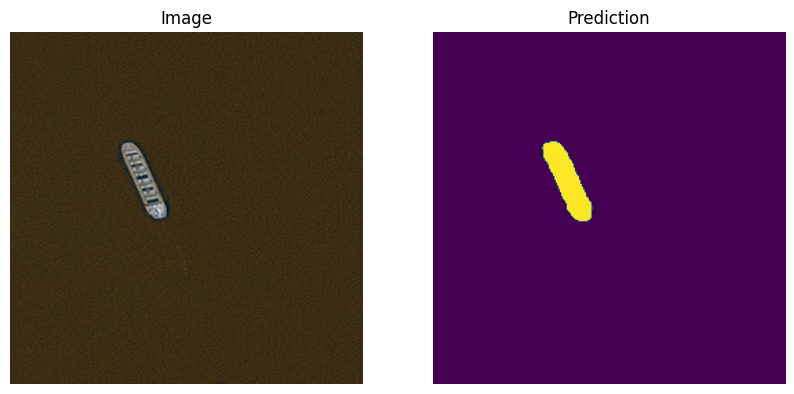

In [35]:
from matplotlib import pyplot as plt
test_imgs = ['00dc34840.jpg', '00c3db267.jpg', '00aa79c47.jpg', '00a3a9d72.jpg', '0010551d9.jpg']
%matplotlib inline

rows = 1
columns = 2
for i in range(len(test_imgs)):
    img, pred = create_pred_gen(test_dir, test_imgs[i], fullres_model)
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(pred, interpolation=None)
    plt.axis('off')
    plt.title("Prediction")